In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch as th
# import torchmetrics as thm
import LPGNN
import igraph as ig
import networkx as nx
import torch_geometric as pyg

import importlib
import powerlaw

In [18]:
importlib.reload(LPGNN.popularity_similarity)
importlib.reload(LPGNN.visualization.degree_distribution)
importlib.reload(LPGNN.visualization)
importlib.reload(LPGNN.utils)
importlib.reload(LPGNN.labne)
importlib.reload(LPGNN.metrics)

<module 'LPGNN.metrics' from '/home/mf/Documents/IB/Tesis/LPGNN/LPGNN/metrics.py'>

In [24]:
PS = LPGNN.popularity_similarity.generatePSNetwork(N=2000, avg_k=6, gamma=2.4, T=0.2, seed=10)

In [25]:
PS_LaBNE = LPGNN.labne.generateLaBNE(PS)

2000
torch.Size([2000])
Calculating best minimal value for power law fit


In [26]:
PS_LaBNE_hyperbolic_distances = LPGNN.metrics.hyperbolic_distance_matrix(positions=PS_LaBNE.LaBNE_node_polar_positions)

In [27]:
PS_LaBNE_hyperbolic_distances.shape

torch.Size([1999000])

(<Figure size 720x720 with 1 Axes>, <PolarAxesSubplot:>)

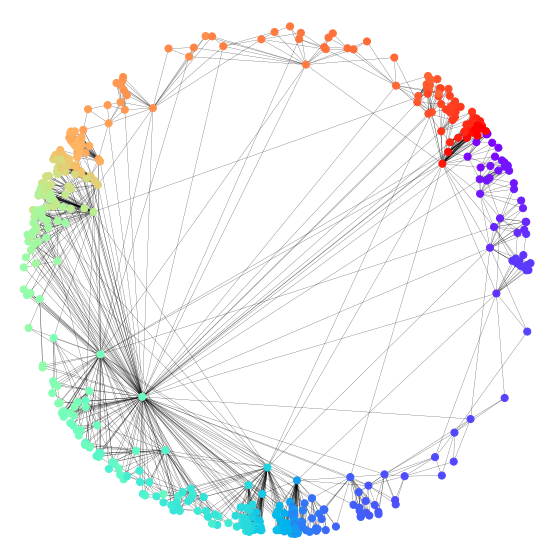

In [42]:
LPGNN.popularity_similarity.drawPSNetwork(PS_LaBNE, pos=PS_LaBNE.LaBNE_node_polar_positions)

In [32]:
np.loadtxt('Network_Files/ASI_t0.txt')

array([[1.0000e+00, 3.0000e+01],
       [1.0000e+00, 3.5000e+02],
       [1.0000e+00, 4.1580e+03],
       ...,
       [1.7089e+04, 2.1567e+04],
       [1.7090e+04, 2.4066e+04],
       [1.7135e+04, 1.9271e+04]])

In [28]:
ASI = th.Tensor(np.loadtxt('Network_Files/ASI_t0.txt')).T.type(th.int64)
ASI = pyg.utils.to_undirected(ASI)
ASI = pyg.data.Data(edge_index=ASI)

In [29]:
ASI_LaBNE = LPGNN.labne.generateLaBNE(ASI, only_coordinates=False)

/home/mf/anaconda3/envs/MachineLearning/lib/python3.8/site-packages/torch_geometric/data/storage.py:259: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


24092
torch.Size([24092])
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


In [31]:
ASI_LaBNE

Data(edge_index=[2, 119062], LaplacianEigenmaps_node_positions=[24092, 2], LaBNE_node_polar_positions=[24092, 2])

In [34]:
x, y, r, theta = ASI_LaBNE.LaplacianEigenmaps_node_positions[:,0], ASI_LaBNE.LaplacianEigenmaps_node_positions[:,1], \
                 ASI_LaBNE.LaBNE_node_polar_positions[:,0], ASI_LaBNE.LaBNE_node_polar_positions[:,1]

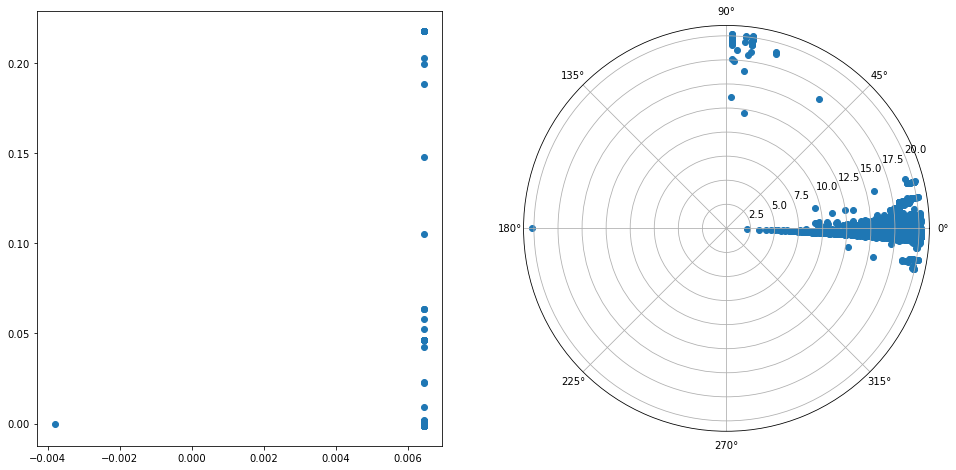

In [35]:
fig = plt.figure(figsize=(16,8))
ax_c = plt.subplot(121)
ax_p = plt.subplot(122, projection='polar')
ax_c.scatter(x,y)
ax_p.scatter(theta, r)

In [ ]:
ASI_LaBNE_hyperbolic_distances = LPGNN.metrics.hyperbolic_distance_matrix(positions=ASI_LaBNE.LaBNE_node_polar_positions)

In [15]:
degrees = pyg.utils.degree(PS.edge_index[0])
fit = LPGNN.utils.infer_gamma(PS)

Calculating best minimal value for power law fit


In [8]:
fit.power_law.xmin+fit.power_law.pdf().shape[0]

1680.0

In [9]:
np.arange(fit.power_law.xmin, fit.power_law.xmin+fit.power_law.pdf().shape[0])

array([  13.,   14.,   15., ..., 1677., 1678., 1679.])

In [44]:
fit.power_law.pdf()
fit.power_law.xmax

Calculating best minimal value for power law fit


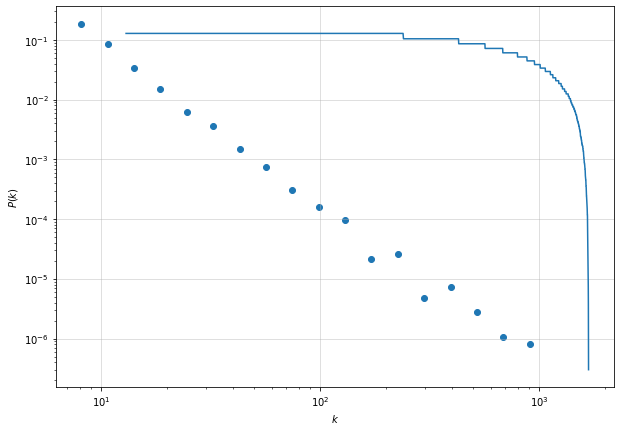

In [11]:
fig = LPGNN.visualization.plot_degree_distribution(PS, log_scale=True, fit_powerlaw=True)

In [16]:
fit = powerlaw.Fit(pyg.utils.degree(PS.edge_index[0]))

Calculating best minimal value for power law fit


In [17]:
fit.alpha

3.143045215517706

In [18]:
LPGNN.labne.infer_gamma(PS)

tensor(2.5379)

In [52]:
tree = nx.balanced_tree(4, 4)
tree_ig = ig.Graph.from_networkx(tree)
tree_labne = LPGNN.network_generator.generateLaBNE(graph=tree_ig)

In [238]:
def nx_to_edgelist(G, filename):
    f = open(filename, 'w')
    f.write('id1,id2,weight\n')
    for edge in G.edges:
        f.write(str(edge[0])+','+str(edge[1])+',1\n')
    f.close()
    
def ig_to_edgelist(G, filename):
    f = open(filename, 'w')
    f.write('id1,id2,weight\n')
    for edge in G.get_edgelist():
        f.write(str(edge[0])+','+str(edge[1])+',1\n')
    f.close()

In [5]:
nx_to_edgelist(G=tree, filename='tree_edgelist.csv')

In [13]:
ig_to_edgelist(G=PS, filename='PS_edgelist.csv')

In [37]:
chkpnt = th.load('Repos/poincare_embeddings/tree.pth.best')
embeddings = chkpnt['model']['lt.weight']
x, y = embeddings.T

In [38]:
pos = {}
for i, node in enumerate(tree.nodes):
    pos[i] = np.array([x[i], y[i]])

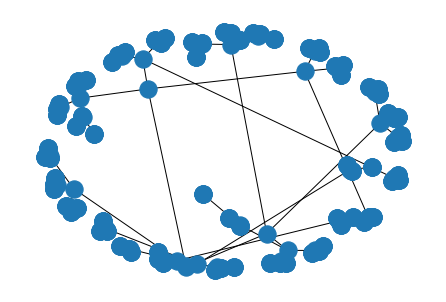

In [39]:
nx.draw(tree, pos)

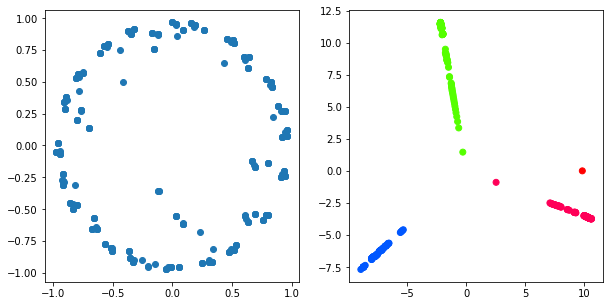

In [40]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

axs[0].scatter(x, y)
axs[1].scatter(tree_labne.vs['r']*np.cos(tree_labne.vs['theta']), tree_labne.vs['r']*np.sin(tree_labne.vs['theta']), c=tree_labne.vs['color'])

In [54]:
PS_poincare_positions = PS.copy()

In [58]:
PS_poincare_positions.vs['x'] = x.detach().numpy()
PS_poincare_positions.vs['y'] = y.detach().numpy()
PS_labne.vs['x'] = PS_labne.vs['r']*np.cos(PS_labne.vs['theta'])
PS_labne.vs['y'] = PS_labne.vs['r']*np.sin(PS_labne.vs['theta'])

In [41]:
tree_ig.vs['x'] = x.detach().numpy()
tree_ig.vs['y'] = y.detach().numpy()

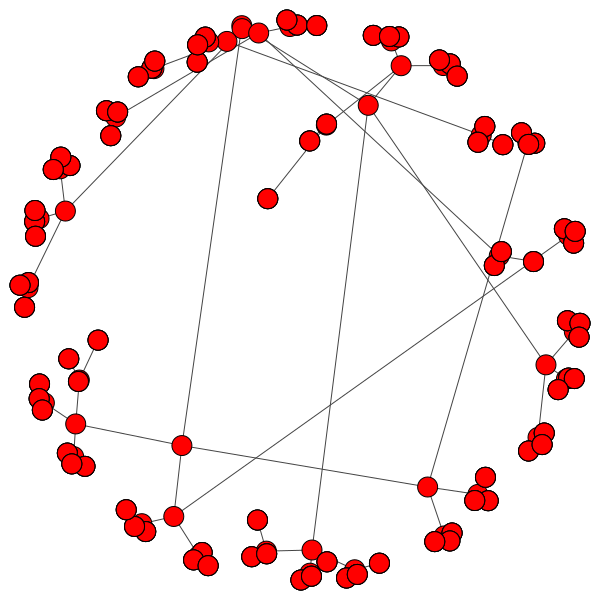

In [42]:
ig.plot(tree_ig)

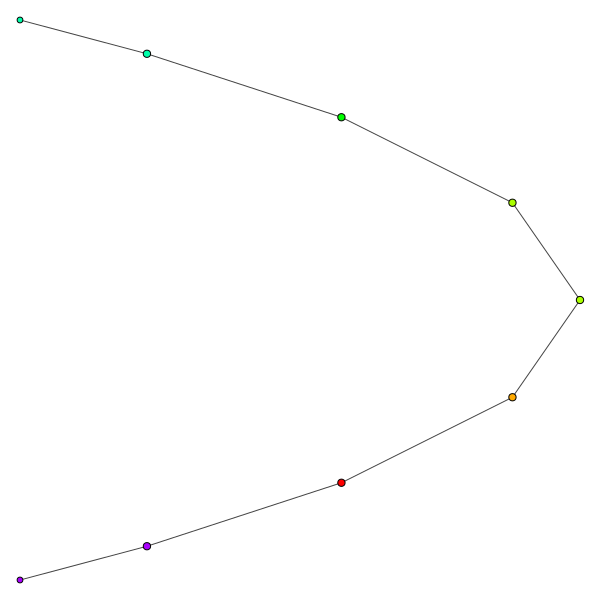

In [207]:
ig.plot(tree_labne)

In [6]:
chkpnt

{'conf': {'checkpoint': 'PS.pth',
  'dset': 'PS_edgelist.csv',
  'dim': 2,
  'manifold': 'poincare',
  'model': 'distance',
  'lr': 0.3,
  'epochs': 300,
  'batchsize': 100,
  'negs': 50,
  'burnin': 20,
  'dampening': 0.75,
  'ndproc': 4,
  'eval_each': 1,
  'fresh': True,
  'debug': False,
  'gpu': -1,
  'sym': False,
  'maxnorm': 500000,
  'sparse': True,
  'burnin_multiplier': 0.01,
  'neg_multiplier': 1.0,
  'quiet': False,
  'lr_type': 'constant',
  'train_threads': 2,
  'margin': 0.1,
  'eval': 'reconstruction',
  'epoch_start': 0},
 'objects': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  7

In [3]:
from gensim.models.poincare import PoincareModel

In [6]:
max_radius = np.max(PS_labne.vs['r'])
max_radius

12.429216196844383

In [7]:
model = PoincareModel(PS.get_edgelist(), negative=30, alpha=0.01, burn_in=0, size=2)
for node in range(PS.vcount()):
    model.kv[node] = np.array([PS_labne.vs['r'][node]*np.cos(PS_labne.vs['theta'][node])/100/max_radius, 
                               PS_labne.vs['r'][node]*np.sin(PS_labne.vs['theta'][node])/100/max_radius])

In [8]:
model.train(epochs=20, batch_size=40)

In [9]:
ordered_nodes = [node for _, node in sorted(zip(PS.degree(), range(500)))][::-1]

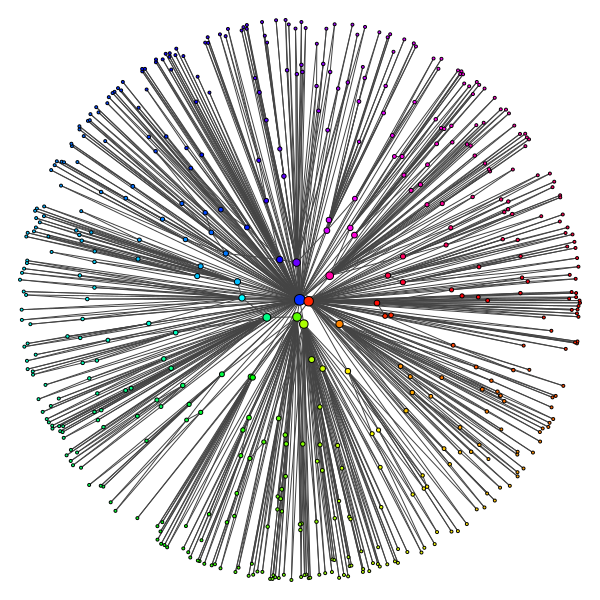

In [10]:
for i, node in enumerate(ordered_nodes):
    PS.vs[node]['x'] = PS.vs[node]['x']*np.log(i+1)
    PS.vs[node]['y'] = PS.vs[node]['y']*np.log(i+1)
ig.plot(PS)

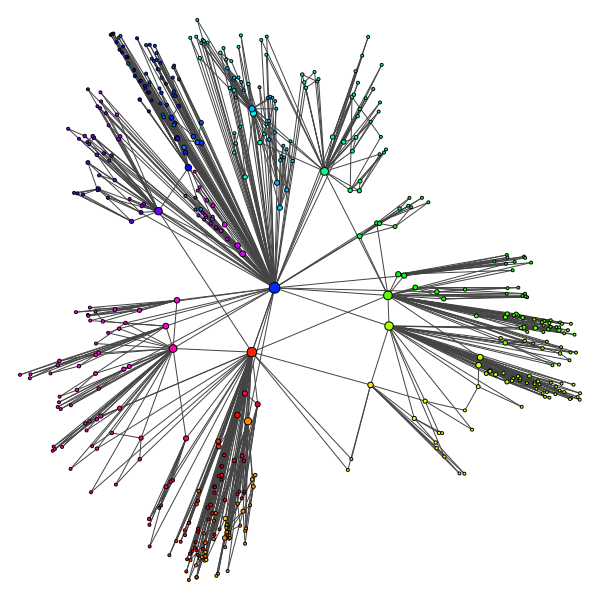

In [12]:
embeddings = np.array([model.kv[node] for node in range(PS.vcount())])
PS.vs['x'] = embeddings[:,0]
PS.vs['y'] = embeddings[:,1]
for i, node in enumerate(ordered_nodes):
    PS.vs[node]['x'] = PS.vs[node]['x']*np.log(i+1)
    PS.vs[node]['y'] = PS.vs[node]['y']*np.log(i+1)
ig.plot(PS)

/home/mf/anaconda3/envs/MachineLearning/lib/python3.8/site-packages/igraph/drawing/edge.py:119: ComplexWarning: Casting complex values to real discards the imaginary part
  ctx.move_to(*src_vertex.position)
/home/mf/anaconda3/envs/MachineLearning/lib/python3.8/site-packages/igraph/drawing/edge.py:131: ComplexWarning: Casting complex values to real discards the imaginary part
  ctx.line_to(*dest_vertex.position)
/home/mf/anaconda3/envs/MachineLearning/lib/python3.8/site-packages/igraph/drawing/shapes.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  ctx.arc(center_x, center_y, width / 2, 0, 2 * pi)


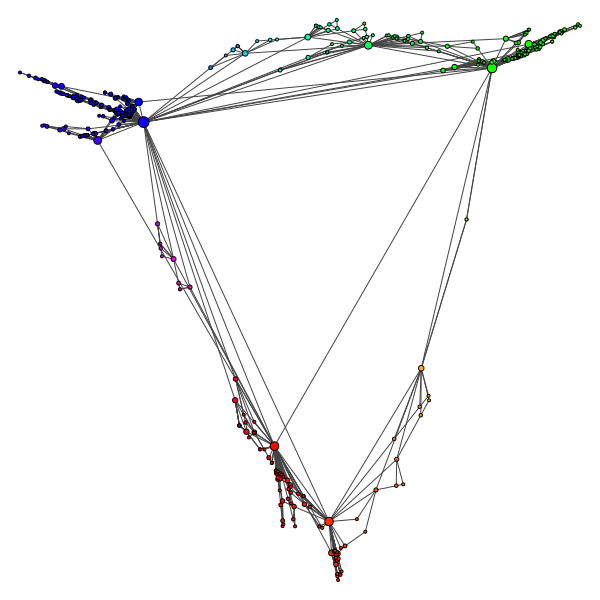

In [15]:
ig.plot(PS_labne)

In [2]:
data = torch_geometric.data.Data(is_directed=False)

In [3]:
data.num_nodes = 100

In [5]:
data.x = th.Tensor([np.random.uniform(0,1,size=2) for i in range(data.num_nodes)])

/tmp/ipykernel_16980/383905087.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811740025/work/torch/csrc/utils/tensor_new.cpp:201.)
  data.x = th.Tensor([np.random.uniform(0,1,size=2) for i in range(data.num_nodes)])


In [10]:
data.position = th.zeros(size=(100,2))

In [71]:
th.range(1,100)

/tmp/ipykernel_16980/3167670576.py:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  th.range(1,100)


tensor([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,
         13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,
         25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,
         37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,
         49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,
         61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,
         73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,
         85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,
         97.,  98.,  99., 100.])

In [17]:
data.position[:,0] = th.log(th.range(1,100))

/tmp/ipykernel_16980/1425020080.py:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  data.position[:,0] = th.log(th.range(1,100))


In [23]:
data.position[:,1] = th.rand(size=(100,))*2*np.pi

In [38]:
th.manual_seed(1)

In [40]:
th.rand((1,))

tensor([0.2793])

In [46]:
data.edge_index = th.Tensor([[1,1,2],[2,3,3]])

In [61]:
torch_geometric.utils.to_undirected(data.edge_index)

tensor([[1., 1., 2., 2., 3., 3.],
        [2., 3., 1., 3., 1., 2.]])

In [64]:
th.Tensor([[i, j] for i in range(5) for j in range(i+1, 5)]).T

tensor([[0., 0., 0., 0., 1., 1., 1., 2., 2., 3.],
        [1., 2., 3., 4., 2., 3., 4., 3., 4., 4.]])

In [73]:
th.arange(0, 5)

tensor([0, 1, 2, 3, 4])

In [88]:
data.edge_index = torch_geometric.utils.to_undirected(th.Tensor([[i, j] for i in th.arange(0, 5) for j in th.arange(i+1, 5)]).T.type(th.int64))

In [91]:
torch_geometric.utils.degree(data.edge_index[0])

tensor([4., 4., 4., 4., 4.])

In [97]:
r_t = np.log(2)

In [99]:
r_s = np.log(np.arange(1,4))

In [100]:
r_t + r_s

array([0.69314718, 1.38629436, 1.79175947])

In [102]:
def f(d, i):
    return th.log(d-d[i])

In [103]:
d = th.Tensor([1,2,3,4,5])

In [137]:
data.position[:,0].shape

torch.Size([100])

In [170]:
d = hyperbolic_distances(data.position[:10], th.Tensor([5,2]))

In [143]:
R_t = 1
T = 1

In [138]:
def hyperbolic_distances(position_list:th.Tensor, position_single:int):
    """Gets the hyperbolic distances between ``position_single`` and list ``position_list``

    Args:
        position_list (th.Tensor): A (N,2) tensor of floats (which indicate (r, theta))
        position_single (th.Tensor): A 2 element tensor which indicates specific (r, theta) pos

    Returns:
        th.Tensor: Tensor of distances, shape (N,1)
    """
    
    #get angular distance between list of positions and index position
    angular_distance = th.min(2*th.pi-th.abs(position_list[:,1]-position_single[1]), th.abs(position_list[:,1]-position_single[1]))
    
    #calculate hyperbolic distance between list of positions and index position
    d = th.arccosh(th.cosh(position_single[0])*th.cosh(position_list[:,0]) - th.sinh(position_single[0])*th.sinh(position_list[:,0])*th.cos(angular_distance))
    return d

In [171]:
p = 1 / (1 + th.exp((d - R_t)/(2*T)))

In [192]:
p.indices.detach().numpy()

array([7, 6, 5, 9, 3, 2, 8, 0, 1, 4])

In [194]:
p

torch.return_types.sort(
values=tensor([0.0532, 0.0538, 0.0586, 0.0628, 0.0824, 0.0843, 0.0883, 0.1192, 0.1224,
        0.1625]),
indices=tensor([7, 6, 5, 9, 3, 2, 8, 0, 1, 4]))

In [198]:
node_kist = np.random.choice(p.indices.detach().numpy(), size=m, p=(p.values/th.sum(p.values)).detach().numpy(), replace=False)

In [199]:
node_kist

array([1, 2, 4, 9, 0])

In [207]:
new_edges =th.Tensor([node_kist, th.empty(5).fill_(4)]).type(th.int64)

In [208]:
new_edges

tensor([[1, 2, 4, 9, 0],
        [4, 4, 4, 4, 4]])

In [223]:
th.cat((data.edge_index, new_edges), dim=1)

tensor([[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 1, 2, 4, 9,
         0],
        [1, 2, 3, 4, 0, 2, 3, 4, 0, 1, 3, 4, 0, 1, 2, 4, 0, 1, 2, 3, 4, 4, 4, 4,
         4]])

In [204]:
data.edge_index

tensor([[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4],
        [1, 2, 3, 4, 0, 2, 3, 4, 0, 1, 3, 4, 0, 1, 2, 4, 0, 1, 2, 3]])